## Rationale

Explain

## Plan

1. Think about how to define 'model fit', i.e. when is a model good?
2. Computing model fit for a given model
3. Comparing model fit across participants and models

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = os.path.realpath('.')
print(base_dir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial


## Functions from before

##### Choice models

In [3]:
def inequity_aversion(params, offer):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = [offer, 0]
    inequities = [(100-offer)-offer, 0]
    utilities = payoffs - np.multiply(params[0],inequities)
    choice = np.where(utilities == np.max(utilities))[0][0]

    return choice

In [4]:
def random_model(params, offer):
    
    choice = np.random.randint(0,2)
    
    return choice

##### Simulation code

In [5]:
def simulate_model(model, data_to_simulate, params = None):
    
    # Input variables: ...asdoaijsoiajc
    
    # Create output dataframe
    simulation_results = data_to_simulate.copy()
    
    # Loop over trials and simulate each trial
    for trial in data_to_simulate['trial']:
        offer = data_to_simulate.loc[data_to_simulate['trial']==trial, 'offer'].values[0]
        predicted_choice = model(params, offer)
        # store in output dataframe:
        simulation_results.loc[data_to_simulate['trial']==trial,'choice'] = predicted_choice
        
    return simulation_results

In [6]:
def plot_simulation(simulated_sub_data):
    
    fig = sns.scatterplot(data = simulated_sub_data, x = 'offer', y = 'choice')
    
    return fig

## Load some data

In [7]:
data_dir = base_dir + '/Data'
print(data_dir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial/Data


In [8]:
data = pd.read_csv(data_dir + '/Study1_UG.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


## 1.How to define model fit?

Let's start with a metric of model fit that you might know from regression: the sum of squared error (SSE).

## Compute model fit for our two models

- Step 1: plot a model + some data to see how well they overlap
- Step 2: compute the model fit

In [9]:
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
340,1,30,0
341,2,45,0
342,3,20,1
343,4,40,0
344,5,40,0


##### EXERCISE: Plot the subject's data as well as simulated data from the random model side-by-side

To do this, use.... (existing python functions, packages, or computations)

[(-0.1, 1.1),
 Text(0, 0.5, 'choice'),
 Text(0.5, 0, 'offer'),
 Text(0.5, 1.0, 'SIMULATION')]

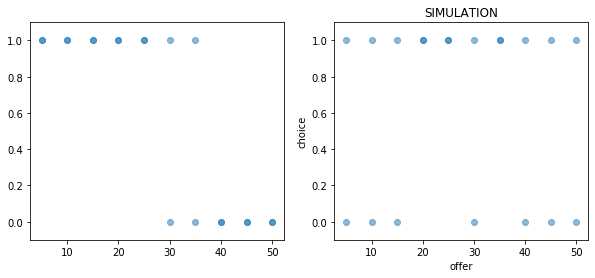

In [10]:
# Make a figure with two axes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])

# Plot data
axes[0].scatter(x = sub_data['offer'], y = sub_data['choice'], alpha = .5)
axes[0].set(ylim = [-.1,1.1])

# Simulating the model
data_to_simulate = sub_data.copy()
simulated_data = simulate_model(random_model, data_to_simulate)

# Plot the model
axes[1].scatter(x = simulated_data['offer'], y = simulated_data['choice'], alpha = .5)
axes[1].set(title = 'SIMULATION', xlabel = 'offer', ylabel = 'choice', ylim = [-.1,1.1])

##### Compute model fit for random model

Write what model fit is, and why sum of squared error (SSE) is a good approximation.
1. Absolute => can integrate positive and negative deviations
2. It's used in regression
3. It ensures that outliers have a bigger impact on your error, e.g. 1 outlier can drive up SSE more than 3 near points. Maybe that's a good thing, maybe not?
4. It's simple
5. It allows you to directly compare a point prediction (from your model) and an observation data point (we will work with probability distributions later on).

In [12]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

Sum of squared error = 9


Now we know how 'good' or 'bad' the model is. But are the errors in one specific direction? For example, a model that always predicts 'accept' will be correct about 'accept' trials 100% of time time, but always wrong about 'reject' trials. To find out, we can use the confusion matrix:

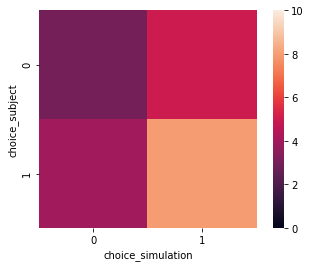

In [13]:
confusion_matrix = (total_data[['choice_subject','choice_simulation','trial']]
                    .groupby(['choice_subject','choice_simulation']).count()
                    .reset_index().pivot(index='choice_subject', columns = 'choice_simulation', values = 'trial'))
sns.heatmap(confusion_matrix, square = True, vmin = 0, vmax = 10)

In [14]:
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

11 hits


##### EXERCISE: Compute model fit for inequity aversion model

In [16]:
simulated_data = simulate_model(inequity_aversion, data_to_simulate, [2])

In [17]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

# Compute number of hits
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

Sum of squared error = 2
18 hits


In this case, the SSE and the number of hits are perfectly correlated (hits = 20 - SSE), so we can pick just one as our objective function (the measure of model fit).

## Model fitting: finding the parameters of the model that yield the best model fit

WRITE some explanation text here about model fitting and grid search.

##### Compute the model fit for many different values of alpha

In [18]:
range_of_alphas = np.arange(0,10,.1)

model_results = pd.DataFrame(columns=['alpha','hits'])

for alpha in range_of_alphas:
    
    # Simulate the model
    simulated_data = simulate_model(inequity_aversion, data_to_simulate, [alpha])
    
    # Merge observed and simulated data
    total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
    
    # Compute hits
    total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
    hits = np.sum(total_data['correct'])
    
    # Store result
    tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
    model_results = model_results.append(tmp)

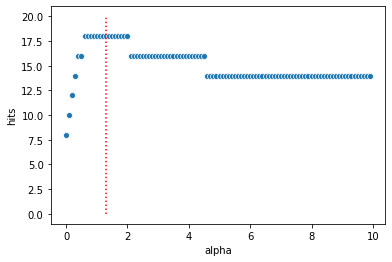

In [19]:
sns.scatterplot(data = model_results, x = 'alpha', y = 'hits')
best_alpha = model_results.query('hits == %i'%np.max(model_results.hits))['alpha'].mean()
plt.plot([best_alpha, best_alpha], [0,20], 'r:')

This plot shows you the value of alpha where you get the maximum number of hits, i.e. the best 'model fit'!

## Fitting the model for different subjects

Now we can automate the fitting procedure and try it for a group of subjects.

##### EXERCISE: Write a function 'subject_fit' that takes subject data and model as inputs and returns the best alpha

In [20]:
def subject_fit(subject_data, model, min_alpha, max_alpha, alpha_step):
    
    range_of_alphas = np.arange(min_alpha, max_alpha, alpha_step)

    model_results = pd.DataFrame(columns=['alpha','hits'])

    for alpha in range_of_alphas:

        # Simulate the model
        simulated_data = simulate_model(model, subject_data, [alpha])

        # Merge observed and simulated data
        total_data = subject_data.merge(simulated_data,
                            on = ['trial','offer'], suffixes = ['_subject', '_simulation'])

        # Compute hits
        total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
        hits = np.sum(total_data['correct'])

        # Store result
        tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
        model_results = model_results.append(tmp)
    
    # Last step: select the best alpha
    best_hits = np.max(model_results['hits'])
    best_alphas = model_results.query('hits == %i'%best_hits)['alpha'].values
    best_alpha = np.mean(best_alphas)
    
    return best_alpha, best_hits, total_data, model_results

In [21]:
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
340,1,30,0
341,2,45,0
342,3,20,1
343,4,40,0
344,5,40,0


In [22]:
best_alpha, best_hits, total_data, model_results = subject_fit(sub_data, inequity_aversion, 0, 10, .1)

##### Loop over subjects

In [68]:
model_fits = pd.DataFrame(columns=['subject','best_alpha','hits'])
for sub in np.arange(1,21):
    print(sub, end = ', ')
    # Load data for a subject
    sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
    sub_data.head()
    # Fit model
    best_alpha, best_hits, total_data, model_results = (
        subject_fit(sub_data, inequity_aversion, 0, 10, .1))
    # Store
    tmp = pd.DataFrame([[sub, best_alpha, best_hits]], columns=model_fits.columns)
    model_fits = model_fits.append(tmp).reset_index(drop=True)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

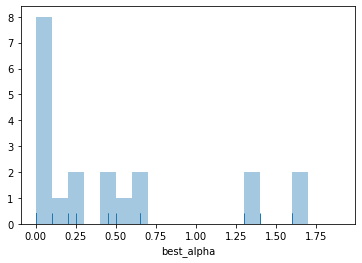

In [83]:
# Plot 1: distribution of alphas
sns.distplot(model_fits['best_alpha'], bins = np.arange(0, 2, .1), rug = True, kde = False)

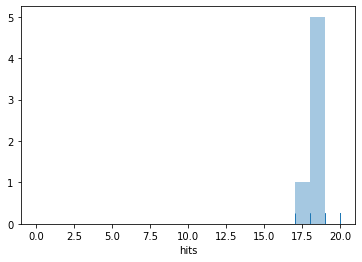

In [82]:
sns.distplot(model_fits['hits'], bins = np.arange(0, 20), kde = False, rug = True)

## During next session, we will:

- Talk about different model fit metrics
- Talk about different choice rules (Softmax, epsilon-greedy)